In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Configure visualization styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("/kaggle/input/salary-data/Salary_Data.csv")
print("Data loaded successfully.")

Data loaded successfully.


In [4]:
df.head()

Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [6]:
df.describe()

Age  Years of Experience         Salary
count  6702.000000          6701.000000    6699.000000
mean     33.620859             8.094687  115326.964771
std       7.614633             6.059003   52786.183911
min      21.000000             0.000000     350.000000
25%      28.000000             3.000000   70000.000000
50%      32.000000             7.000000  115000.000000
75%      38.000000            12.000000  160000.000000
max      62.000000            34.000000  250000.000000

In [7]:
print(df.isnull().sum())

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64


In [8]:
# Drop rows with any missing values
df.dropna(inplace=True)
df.isnull().sum()

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64

In [9]:
print("\nValue counts for Job Title (Top 20):")
print(df['Job Title'].value_counts().head(20))
print(f"\nTotal unique Job Titles before consolidation: {df['Job Title'].nunique()}")


Value counts for Job Title (Top 20):
Job Title
Software Engineer            518
Data Scientist               453
Software Engineer Manager    376
Data Analyst                 363
Senior Project Engineer      318
Product Manager              313
Full Stack Engineer          308
Marketing Manager            255
Back end Developer           244
Senior Software Engineer     244
Front end Developer          241
Marketing Coordinator        158
Junior Sales Associate       142
Financial Manager            134
Marketing Analyst            132
Software Developer           125
Operations Manager           114
Human Resources Manager      104
Director of Marketing         88
Web Developer                 87
Name: count, dtype: int64

Total unique Job Titles before consolidation: 191


In [10]:
job_title_counts = df['Job Title'].value_counts()
titles_to_group = job_title_counts[job_title_counts <= 25].index

df['Job Title'] = df['Job Title'].apply(lambda x: 'Others' if x in titles_to_group else x)

print(f"\nTotal unique Job Titles after consolidation: {df['Job Title'].nunique()}")
print("\nValue counts for Job Title after consolidation (Top 20):")
print(df['Job Title'].value_counts().head(20))


Total unique Job Titles after consolidation: 50

Value counts for Job Title after consolidation (Top 20):
Job Title
Software Engineer            518
Data Scientist               453
Others                       406
Software Engineer Manager    376
Data Analyst                 363
Senior Project Engineer      318
Product Manager              313
Full Stack Engineer          308
Marketing Manager            255
Senior Software Engineer     244
Back end Developer           244
Front end Developer          241
Marketing Coordinator        158
Junior Sales Associate       142
Financial Manager            134
Marketing Analyst            132
Software Developer           125
Operations Manager           114
Human Resources Manager      104
Director of Marketing         88
Name: count, dtype: int64


In [11]:
print("\nValue counts for Education Level before consolidation:")
print(df['Education Level'].value_counts())

# Standardize education level names
df['Education Level'].replace({
    "Bachelor's Degree": "Bachelor's",
    "Master's Degree": "Master's",
    "phD": "PhD" 
}, inplace=True)

print("\nValue counts for Education Level after consolidation:")
print(df['Education Level'].value_counts())


Value counts for Education Level before consolidation:
Education Level
Bachelor's Degree    2265
Master's Degree      1572
PhD                  1368
Bachelor's            756
High School           448
Master's              288
phD                     1
Name: count, dtype: int64

Value counts for Education Level after consolidation:
Education Level
Bachelor's     3021
Master's       1860
PhD            1369
High School     448
Name: count, dtype: int64


In [12]:
print("\nValue counts for Gender:")
print(df['Gender'].value_counts())


Value counts for Gender:
Gender
Male      3671
Female    3013
Other       14
Name: count, dtype: int64


# Exploratory Data Analysis

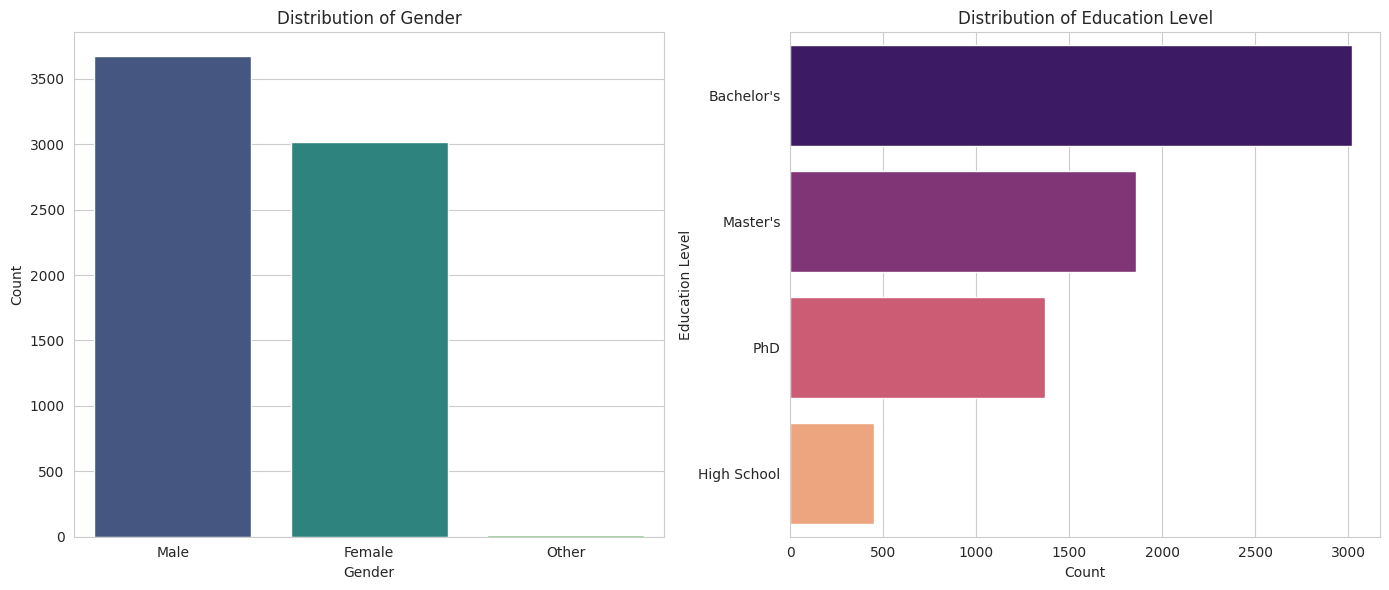

In [13]:
# Distribution of Categorical Features
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x='Gender', data=df, ax=ax[0], palette='viridis', order=df['Gender'].value_counts().index)
ax[0].set_title('Distribution of Gender')
ax[0].set_xlabel('Gender')
ax[0].set_ylabel('Count')

sns.countplot(y='Education Level', data=df, ax=ax[1], palette='magma', order=df['Education Level'].value_counts().index)
ax[1].set_title('Distribution of Education Level')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Education Level')

plt.tight_layout()
plt.show()

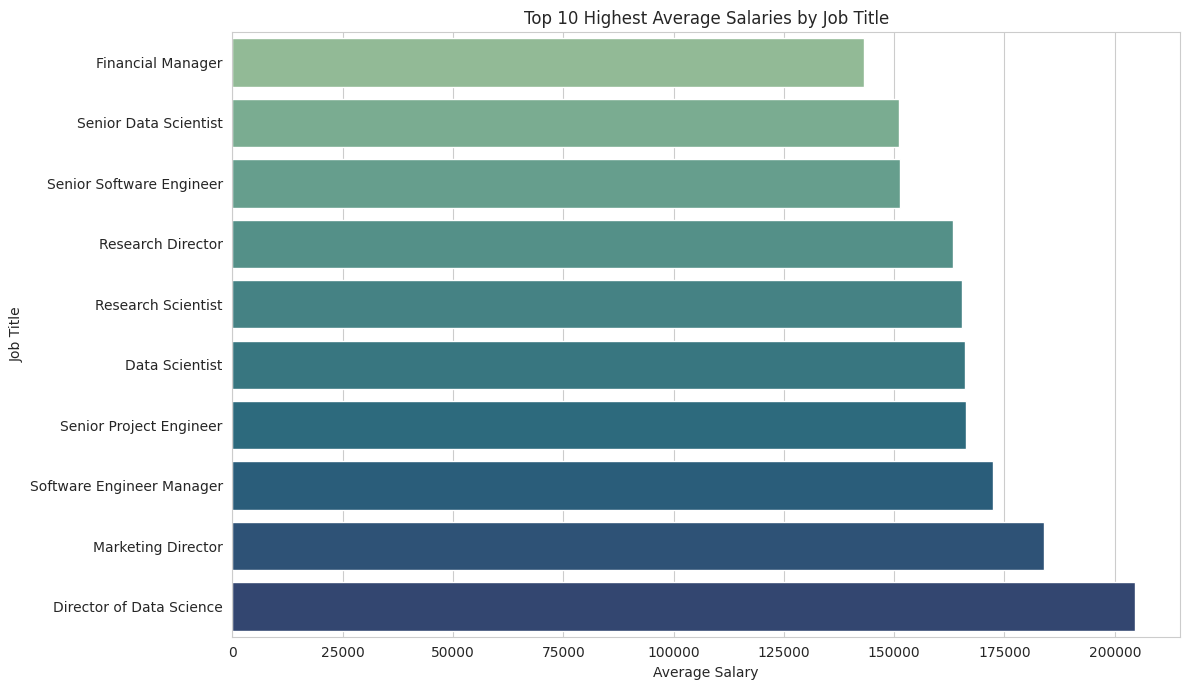

In [14]:
# Top 10 Highest Paying Job Titles (using consolidated titles)
plt.figure(figsize=(12, 7))
top_paying_jobs = df.groupby('Job Title')['Salary'].mean().nlargest(10).sort_values()

sns.barplot(y=top_paying_jobs.index, x=top_paying_jobs.values, palette='crest')
plt.title('Top 10 Highest Average Salaries by Job Title')
plt.xlabel('Average Salary')
plt.ylabel('Job Title')
plt.xticks(rotation=0) # Keep x-axis labels horizontal for salary
plt.tight_layout()
plt.show()

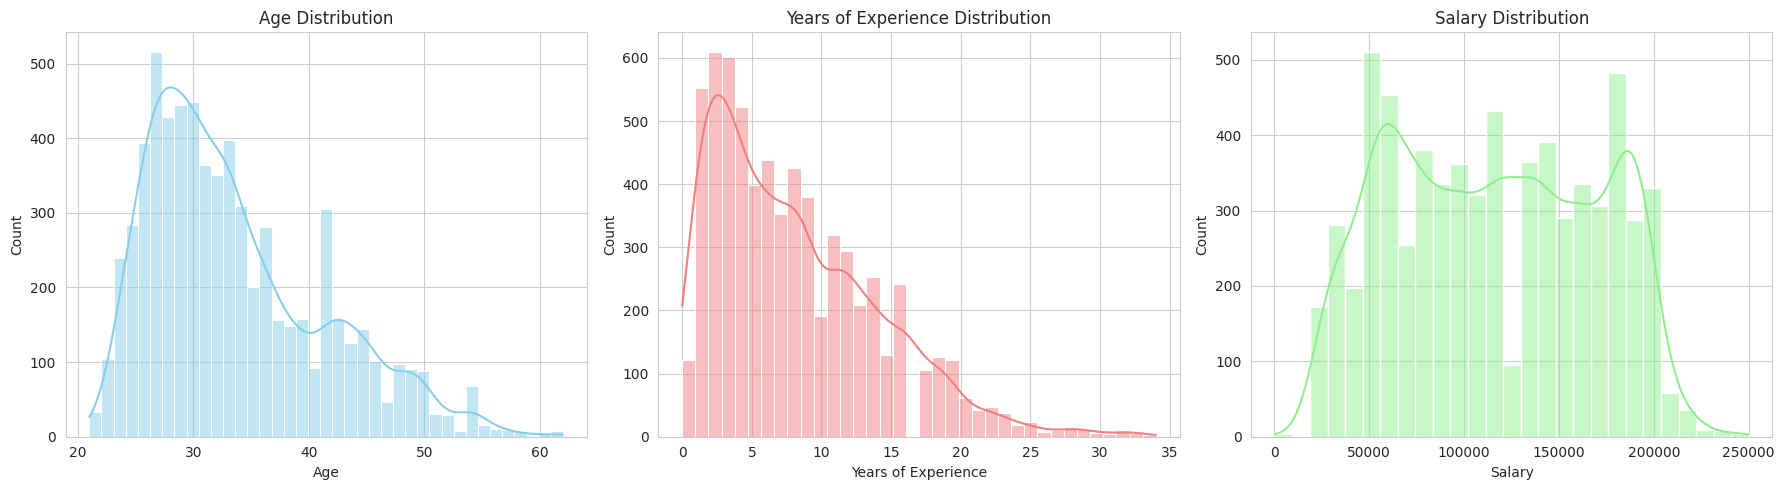

In [15]:
# Distribution of Continuous Variables
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['Age'], ax=ax[0], color='skyblue', kde=True)
ax[0].set_title('Age Distribution')
ax[0].set_xlabel('Age')

sns.histplot(df['Years of Experience'], ax=ax[1], color='lightcoral', kde=True)
ax[1].set_title('Years of Experience Distribution')
ax[1].set_xlabel('Years of Experience')

sns.histplot(df['Salary'], ax=ax[2], color='lightgreen', kde=True)
ax[2].set_title('Salary Distribution')
ax[2].set_xlabel('Salary')

plt.tight_layout()
plt.show()

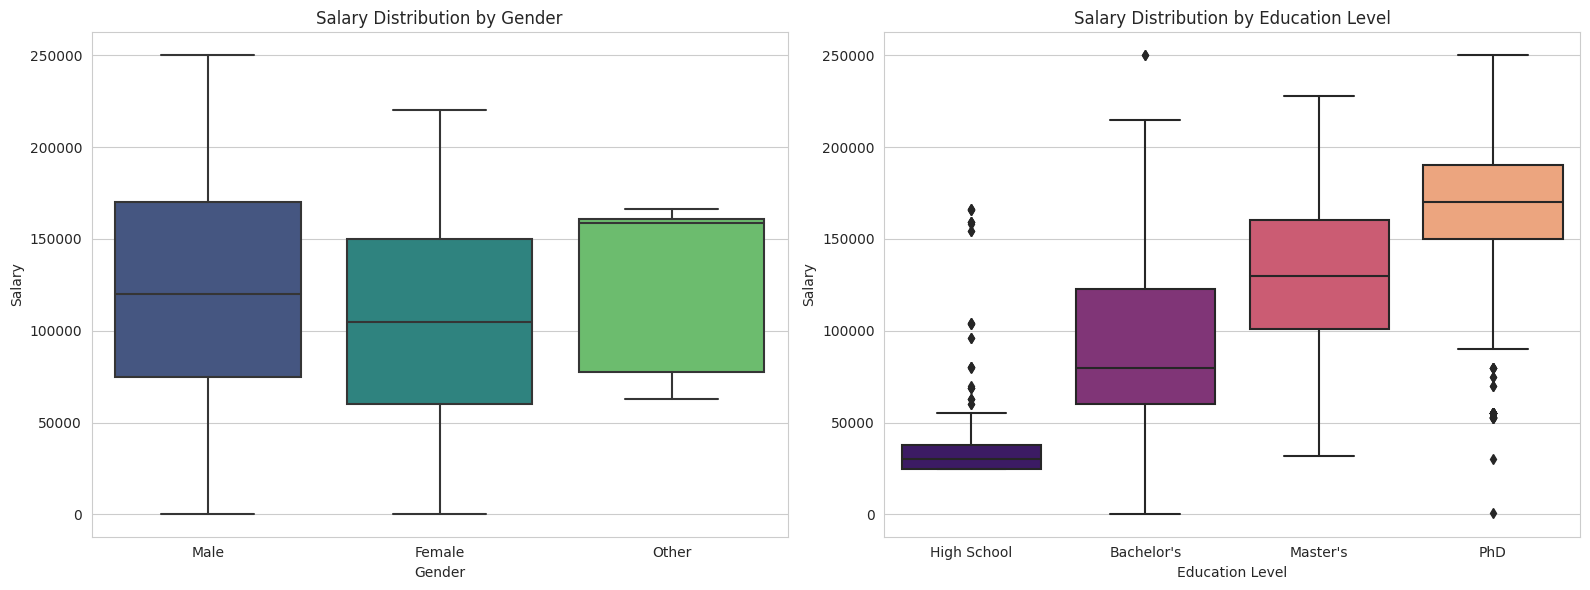

In [16]:
# Salary vs. Categorical Features
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Gender vs Salary
sns.boxplot(x='Gender', y='Salary', data=df, ax=ax[0], palette='viridis', order=['Male', 'Female', 'Other'])
ax[0].set_title('Salary Distribution by Gender')
ax[0].set_xlabel('Gender')
ax[0].set_ylabel('Salary')

# Education Level vs Salary
# Define order for better visualization
edu_order = ["High School", "Bachelor's", "Master's", "PhD"]
sns.boxplot(x='Education Level', y='Salary', data=df, ax=ax[1], palette='magma', order=edu_order)
ax[1].set_title('Salary Distribution by Education Level')
ax[1].set_xlabel('Education Level')
ax[1].set_ylabel('Salary')
ax[1].tick_params(axis='x', rotation=0) # Keep labels horizontal

plt.tight_layout()
plt.show()

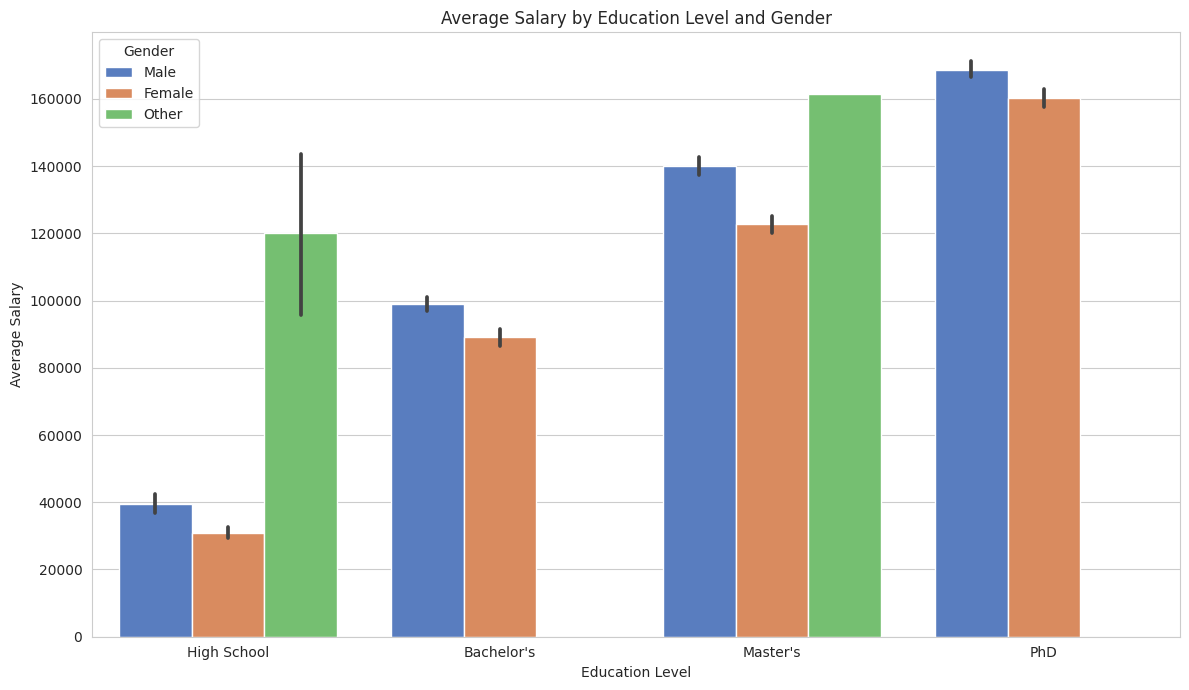

In [17]:
# Interaction: Education Level, Salary, and Gender
plt.figure(figsize=(12, 7))
sns.barplot(x='Education Level', y='Salary', data=df, hue='Gender', palette='muted', order=edu_order)
plt.title('Average Salary by Education Level and Gender')
plt.xlabel('Education Level')
plt.ylabel('Average Salary')
plt.legend(title='Gender')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

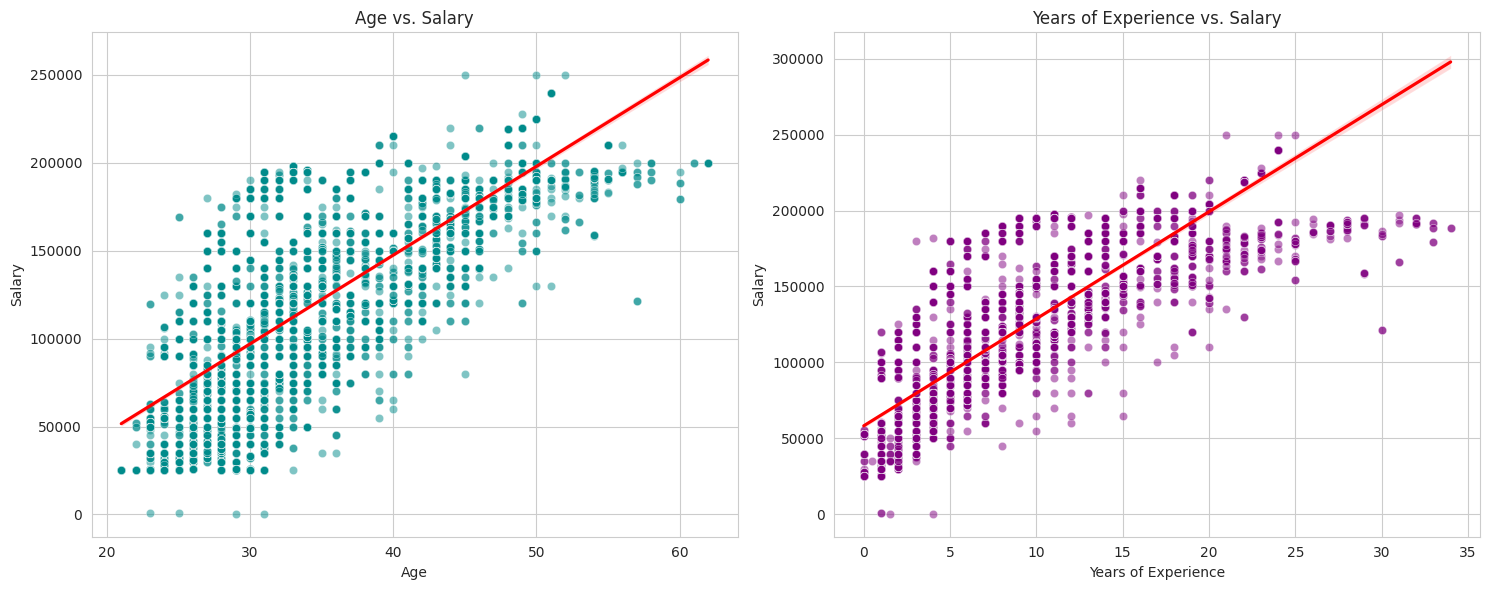

In [18]:
# Salary vs. Continuous Features (Age, Experience)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Age vs Salary
sns.scatterplot(x='Age', y='Salary', data=df, alpha=0.5, ax=ax[0], color='darkcyan')
sns.regplot(x='Age', y='Salary', data=df, scatter=False, ax=ax[0], color='red') # Add regression line
ax[0].set_title('Age vs. Salary')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Salary')

# Experience vs Salary
sns.scatterplot(x='Years of Experience', y='Salary', data=df, alpha=0.5, ax=ax[1], color='purple')
sns.regplot(x='Years of Experience', y='Salary', data=df, scatter=False, ax=ax[1], color='red') # Add regression line
ax[1].set_title('Years of Experience vs. Salary')
ax[1].set_xlabel('Years of Experience')
ax[1].set_ylabel('Salary')

plt.tight_layout()
plt.show()


Gender Label Encoding Mapping:
Female -> 0
Male -> 1
Other -> 2


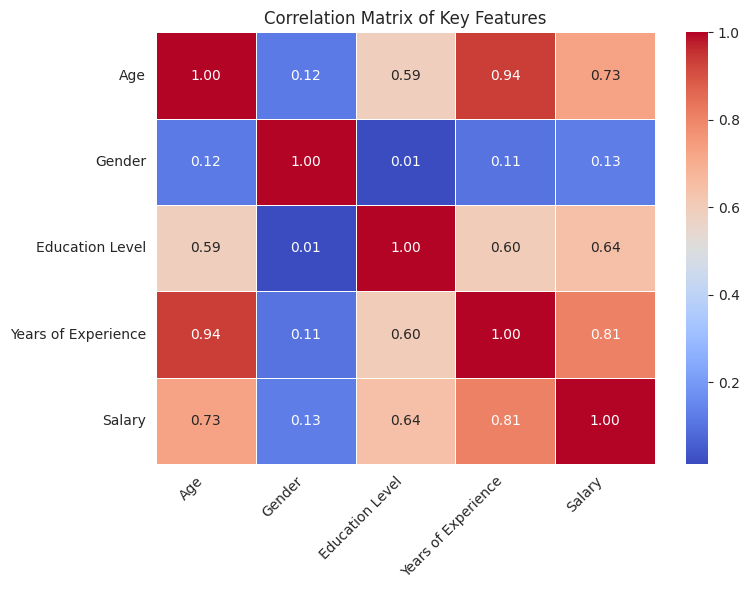

In [19]:
# Correlation Heatmap 
df_encoded = df.copy()

# Map Education Level: Use ordinal mapping as there's a clear order
education_mapping = {"High School": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3}
df_encoded['Education Level'] = df_encoded['Education Level'].map(education_mapping)

# Label Encode Gender
le = LabelEncoder()
df_encoded['Gender'] = le.fit_transform(df_encoded['Gender'])
# Print gender mapping for clarity
print("\nGender Label Encoding Mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name} -> {i}")

# One-Hot Encode Job Title (since it's nominal)
# Calculate correlation matrix on relevant numeric columns
numeric_cols = ['Age', 'Gender', 'Education Level', 'Years of Experience', 'Salary']
correlation_matrix = df_encoded[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#  Data Preparation

In [20]:
# Map Education Level
df['Education Level'] = df['Education Level'].map(education_mapping)

# Label Encode Gender
df['Gender'] = le.transform(df['Gender'])

# One-Hot Encode 'Job Title'
df = pd.get_dummies(df, columns=['Job Title'], drop_first=True, prefix='Job')

print("\nDataFrame columns after One-Hot Encoding Job Titles:")
print(df.columns)
print("\nFirst 5 rows of the final preprocessed data:")
df.head()


DataFrame columns after One-Hot Encoding Job Titles:
Index(['Age', 'Gender', 'Education Level', 'Years of Experience', 'Salary',
       'Job_Content Marketing Manager', 'Job_Data Analyst',
       'Job_Data Scientist', 'Job_Digital Marketing Manager',
       'Job_Director of Data Science', 'Job_Director of HR',
       'Job_Director of Marketing', 'Job_Financial Analyst',
       'Job_Financial Manager', 'Job_Front End Developer',
       'Job_Front end Developer', 'Job_Full Stack Engineer',
       'Job_Human Resources Coordinator', 'Job_Human Resources Manager',
       'Job_Junior HR Coordinator', 'Job_Junior HR Generalist',
       'Job_Junior Marketing Manager', 'Job_Junior Sales Associate',
       'Job_Junior Sales Representative', 'Job_Junior Software Developer',
       'Job_Junior Software Engineer', 'Job_Junior Web Developer',
       'Job_Marketing Analyst', 'Job_Marketing Coordinator',
       'Job_Marketing Director', 'Job_Marketing Manager',
       'Job_Operations Manager', 'Job_O

Age  Gender  Education Level  Years of Experience    Salary  \
0  32.0       1                1                  5.0   90000.0   
1  28.0       0                2                  3.0   65000.0   
2  45.0       1                3                 15.0  150000.0   
3  36.0       0                1                  7.0   60000.0   
4  52.0       1                2                 20.0  200000.0   

   Job_Content Marketing Manager  Job_Data Analyst  Job_Data Scientist  \
0                          False             False               False   
1                          False              True               False   
2                          False             False               False   
3                          False             False               False   
4                          False             False               False   

   Job_Digital Marketing Manager  Job_Director of Data Science  ...  \
0                          False                         False  ...   
1                          False                         False  ...   
2                          False                         False  ...   
3                          False                         False  ...   
4                          False                         False  ...   

   Job_Senior HR Generalist  Job_Senior Human Resources Manager  \
0                     False                               False   
1                     False                               False   
2                     False                               False   
3                     False                               False   
4                     False                               False   

   Job_Senior Product Marketing Manager  Job_Senior Project Engineer  \
0                                 False                        False   
1                                 False                        False   
2                                 False                        False   
3                                 False                        False   
4                                 False                        False   

   Job_Senior Research Scientist  Job_Senior Software Engineer  \
0                          False                         False   
1                          False                         False   
2                          False                         False   
3                          False                         False   
4                          False                         False   

   Job_Software Developer  Job_Software Engineer  \
0                   False                   True   
1                   False                  False   
2                   False                  False   
3                   False                  False   
4                   False                  False   

   Job_Software Engineer Manager  Job_Web Developer  
0                          False              False  
1                          False              False  
2                          False              False  
3                          False              False  
4                          False              False  

[5 rows x 54 columns]

In [21]:
# Define Features (X) and Target (y)
X = df.drop('Salary', axis=1)
y = df['Salary']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")


Features shape: (6698, 53)
Target shape: (6698,)


In [22]:
# Split data into Training and Testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")


Training set shape: X_train=(5358, 53), y_train=(5358,)
Testing set shape: X_test=(1340, 53), y_test=(1340,)


# Model Training and Hyperparameter Tuning

In [23]:
# Define models and parameter grids for GridSearchCV
model_params = {
    'Linear_Regression': {
        'model': LinearRegression(),
        'params': {
             'fit_intercept': [True, False]
        }
    },
    'Decision_Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10],     
            'min_samples_leaf': [1, 3, 5]
        }
    },
    'Random_Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 150], 
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 3]
        }
    },
    'XGBoost': { # Added XGBoost
        'model': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
        'params': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 0.8, 1.0] # Fraction of samples used per tree
        }
    }
}

In [24]:
# Perform GridSearchCV to find the best parameters for each model
scores = []
best_estimators = {}

print("\nStarting Hyperparameter Tuning (this may take a while)...")

for model_name, mp in model_params.items():
    print(f"--- Tuning {model_name} ---")
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='neg_mean_squared_error', n_jobs=-1, return_train_score=False)
    clf.fit(X_train, y_train)
    
    scores.append({
        'Model': model_name,
        'Best Params': clf.best_params_,
        'Best Negative MSE': clf.best_score_
    })
    best_estimators[model_name] = clf.best_estimator_ # Store the best model instance
    print(f"Best parameters for {model_name}: {clf.best_params_}")
    print(f"Best cross-validation score (Negative MSE): {clf.best_score_:.4f}\n")


Starting Hyperparameter Tuning (this may take a while)...
--- Tuning Linear_Regression ---
Best parameters for Linear_Regression: {'fit_intercept': True}
Best cross-validation score (Negative MSE): -465727213.1585

--- Tuning Decision_Tree ---
Best parameters for Decision_Tree: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation score (Negative MSE): -85699974.9209

--- Tuning Random_Forest ---
Best parameters for Random_Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best cross-validation score (Negative MSE): -69050250.0623

--- Tuning XGBoost ---
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}
Best cross-validation score (Negative MSE): -70001999.4966



In [25]:
# Evaluate the best models found by GridSearchCV on the unseen test set
evaluation_results = []

print("\n--- Evaluating Best Models on Test Set ---")

for model_name, model in best_estimators.items():
    print(f"Evaluating {model_name}...")
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    evaluation_results.append({
        'Model': model_name,
        'R-squared (R2)': r2,
        'Mean Absolute Error (MAE)': mae,
        'Mean Squared Error (MSE)': mse,
        'Root Mean Squared Error (RMSE)': rmse
    })
    
    print(f"  R2 Score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}\n")


--- Evaluating Best Models on Test Set ---
Evaluating Linear_Regression...
  R2 Score: 0.8347
  MAE: 15682.5574
  MSE: 471377946.2901
  RMSE: 21711.2401

Evaluating Decision_Tree...
  R2 Score: 0.9664
  MAE: 3753.9697
  MSE: 95786559.3528
  RMSE: 9787.0608

Evaluating Random_Forest...
  R2 Score: 0.9734
  MAE: 3334.8376
  MSE: 75866882.9976
  RMSE: 8710.1598

Evaluating XGBoost...
  R2 Score: 0.9702
  MAE: 4272.6974
  MSE: 85062222.2381
  RMSE: 9222.9183



In [26]:
# Display evaluation results in a DataFrame
evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df = evaluation_df.sort_values(by='R-squared (R2)', ascending=False)

print("\n--- Test Set Evaluation Summary (Sorted by R-squared) ---")
evaluation_df


--- Test Set Evaluation Summary (Sorted by R-squared) ---


Model  R-squared (R2)  Mean Absolute Error (MAE)  \
2      Random_Forest        0.973394                3334.837574   
3            XGBoost        0.970169                4272.697398   
1      Decision_Tree        0.966408                3753.969744   
0  Linear_Regression        0.834689               15682.557358   

   Mean Squared Error (MSE)  Root Mean Squared Error (RMSE)  
2              7.586688e+07                     8710.159757  
3              8.506222e+07                     9222.918315  
1              9.578656e+07                     9787.060813  
0              4.713779e+08                    21711.240091

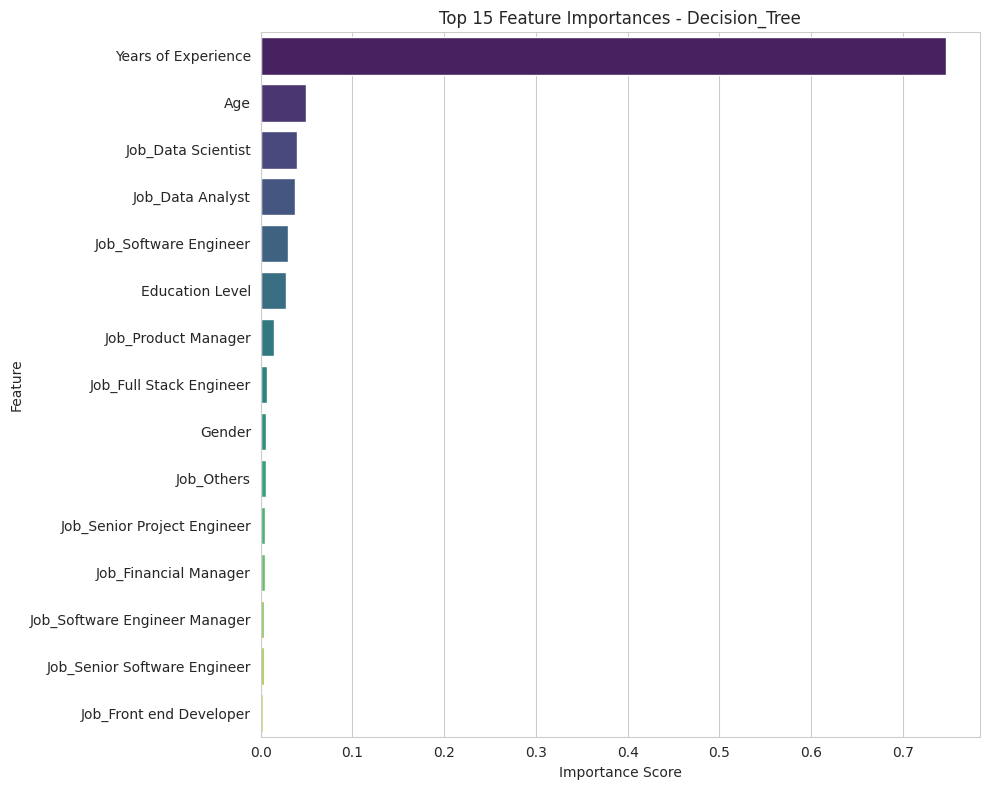

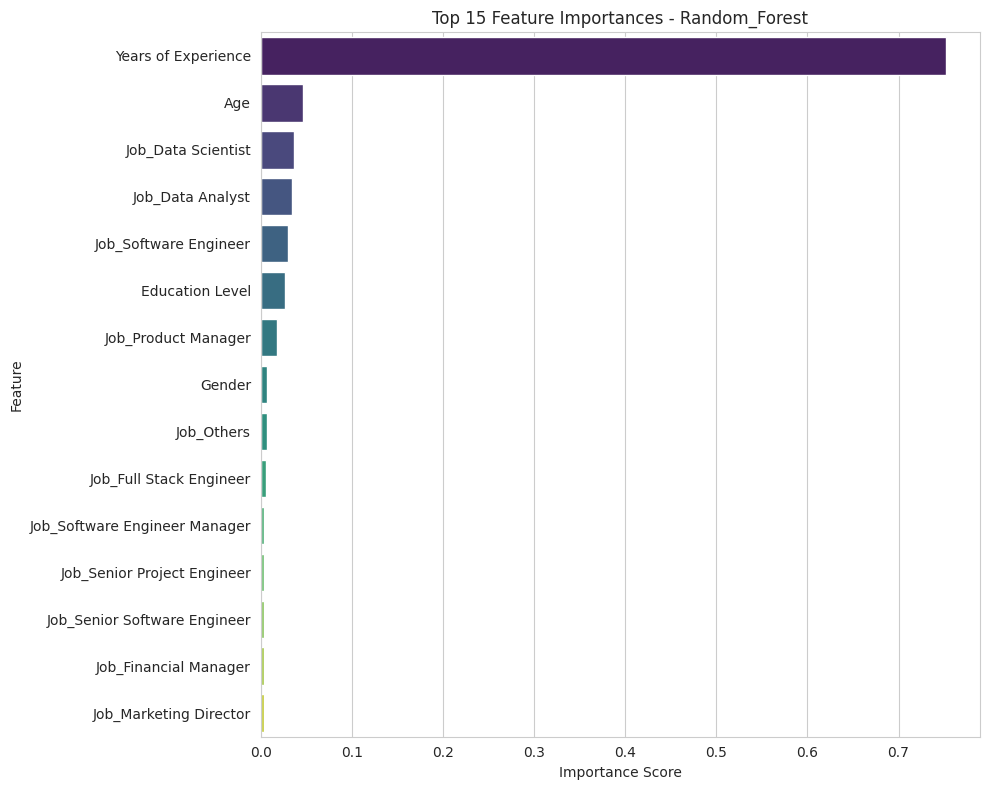

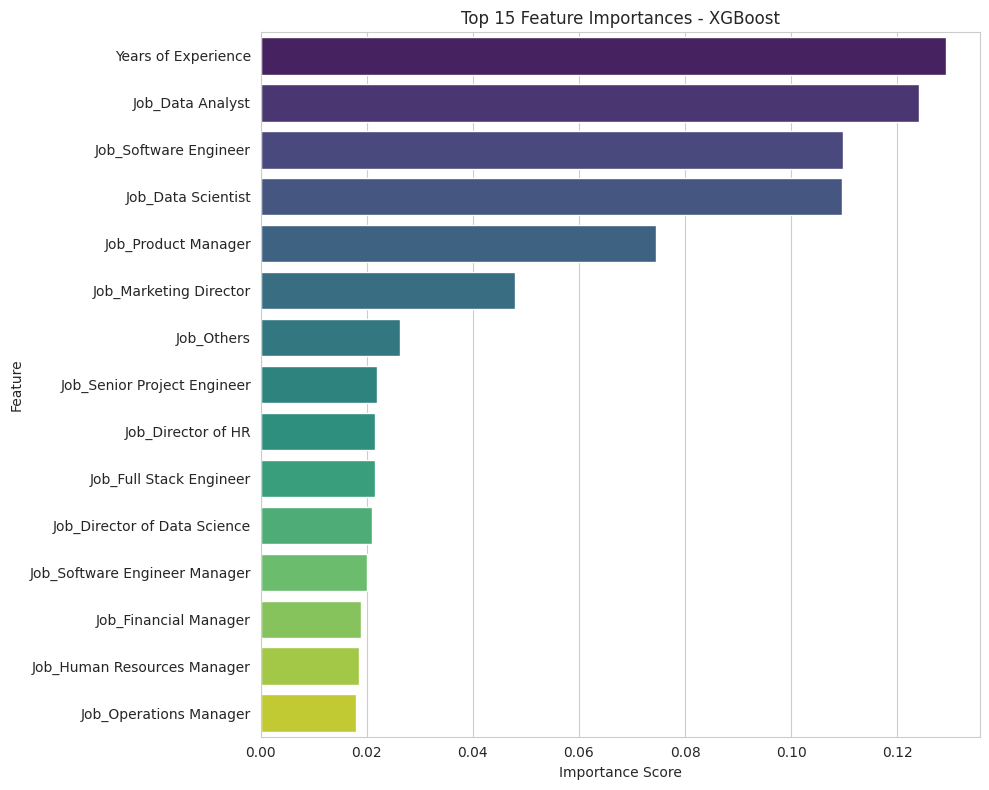

In [27]:
# Analyze feature importances for tree-based models (DT, RF, XGB)

models_for_importance = {
    'Decision_Tree': best_estimators.get('Decision_Tree'),
    'Random_Forest': best_estimators.get('Random_Forest'),
    'XGBoost': best_estimators.get('XGBoost')
}

num_features_to_show = 15

for model_name, model in models_for_importance.items():
    if model is None or not hasattr(model, 'feature_importances_'):
        print(f"\nSkipping feature importance for {model_name} (model not found or doesn't support it).")
        continue
        
    importances = model.feature_importances_
    feature_names = X_train.columns
    
    # Create a DataFrame for better handling
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    
    # Sort features by importance and select top N
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(num_features_to_show)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Top {num_features_to_show} Feature Importances - {model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Visualizing the Decision Tree


Visualizing the first 5 trees from the Random Forest model (up to depth 2)...


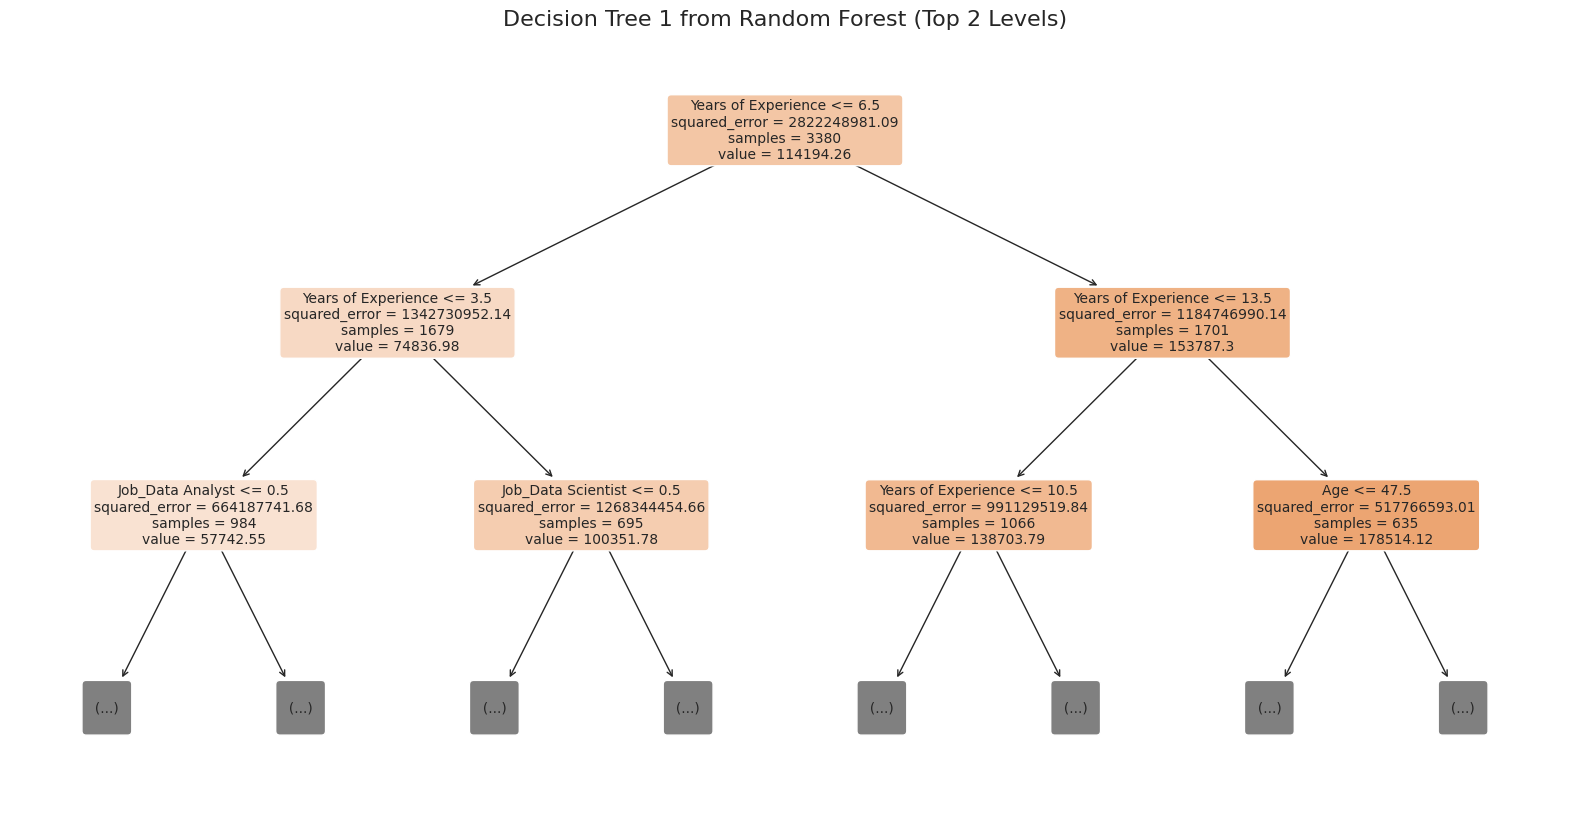

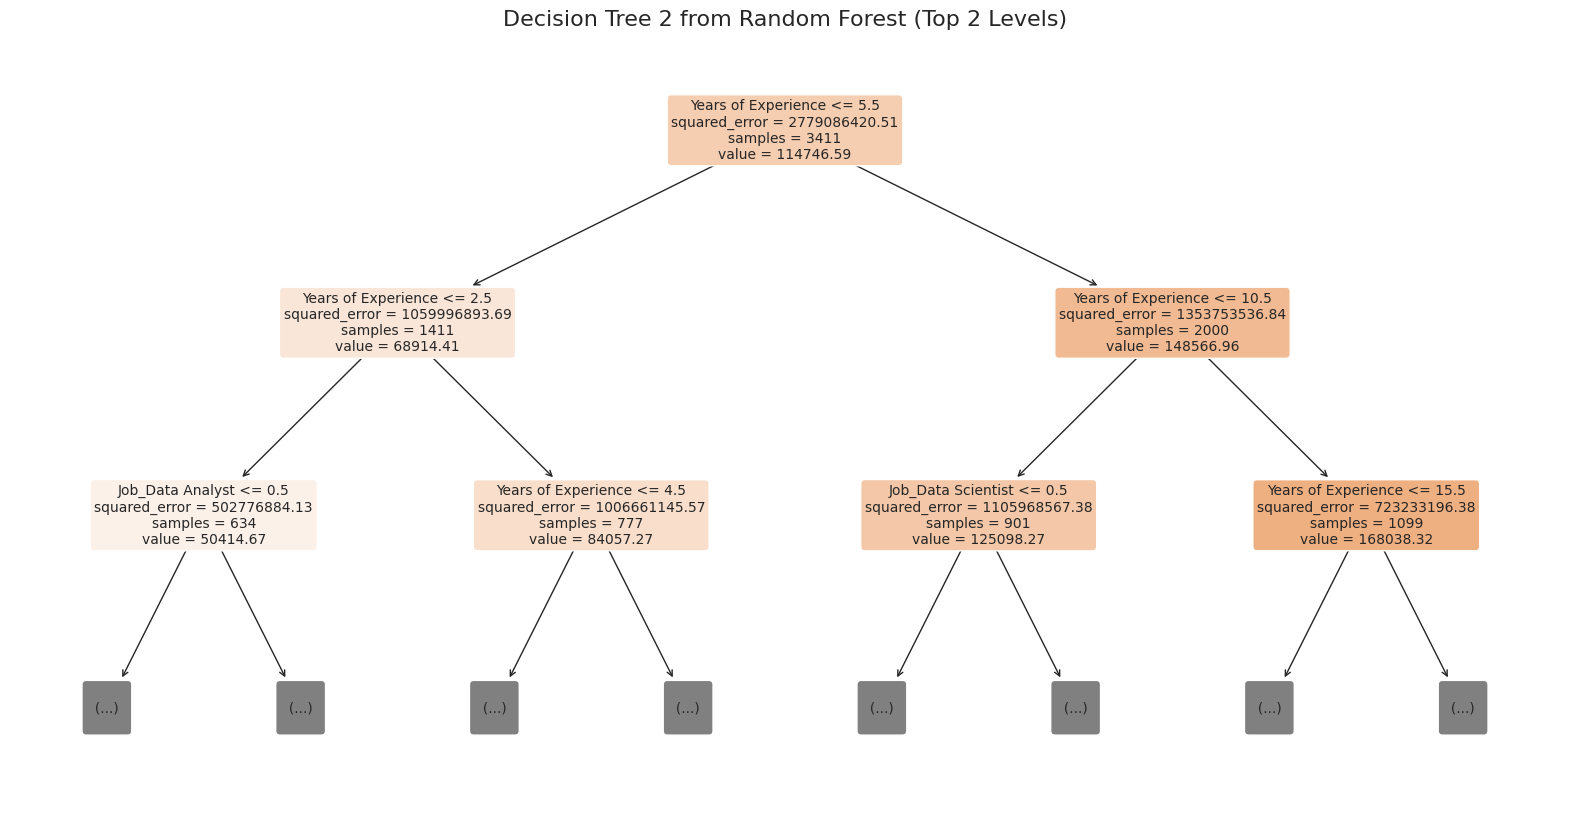

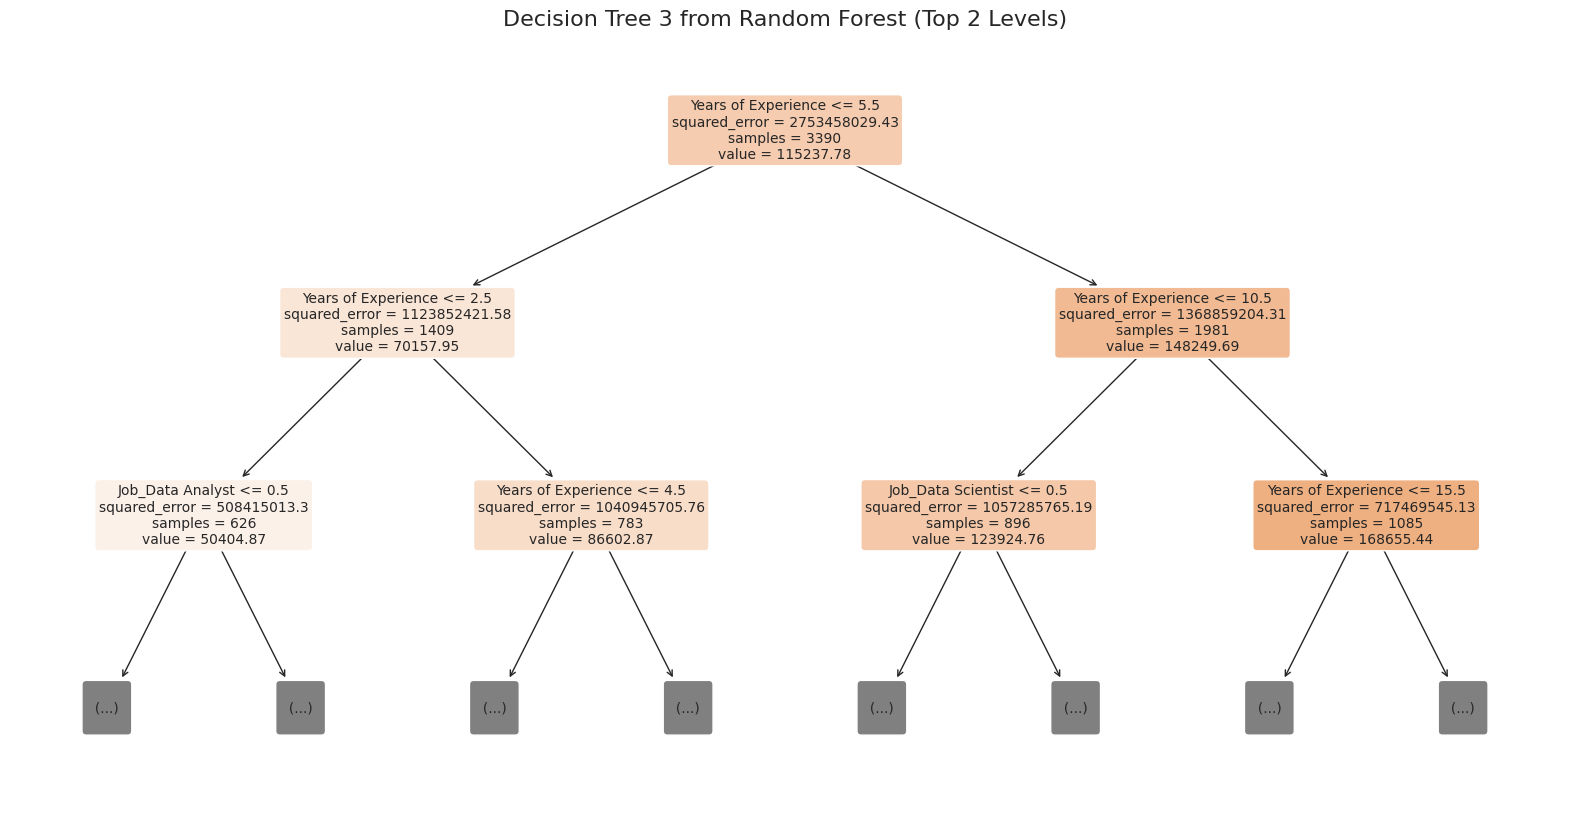

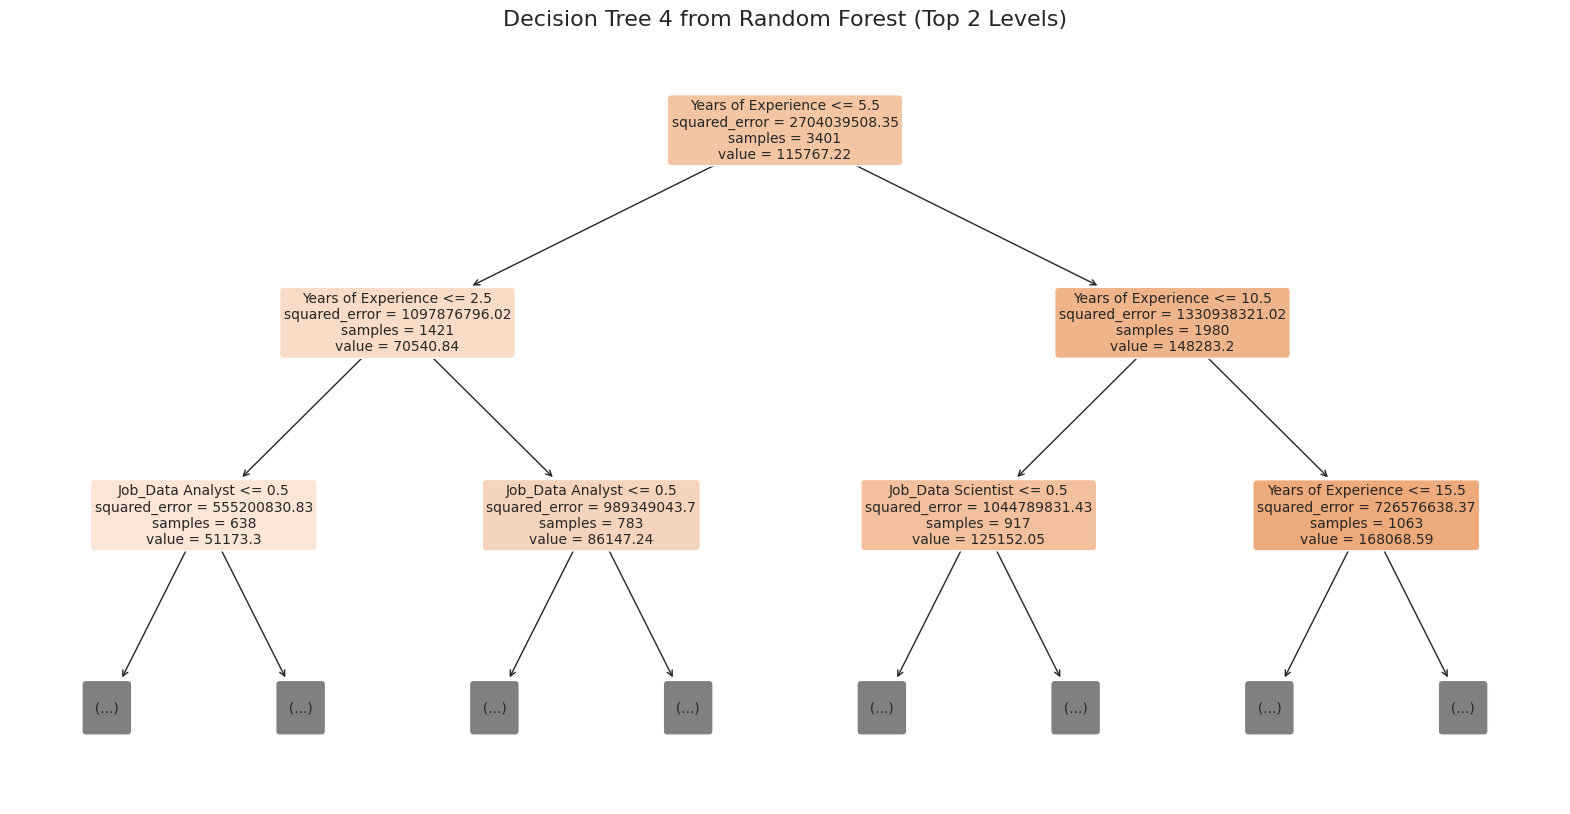

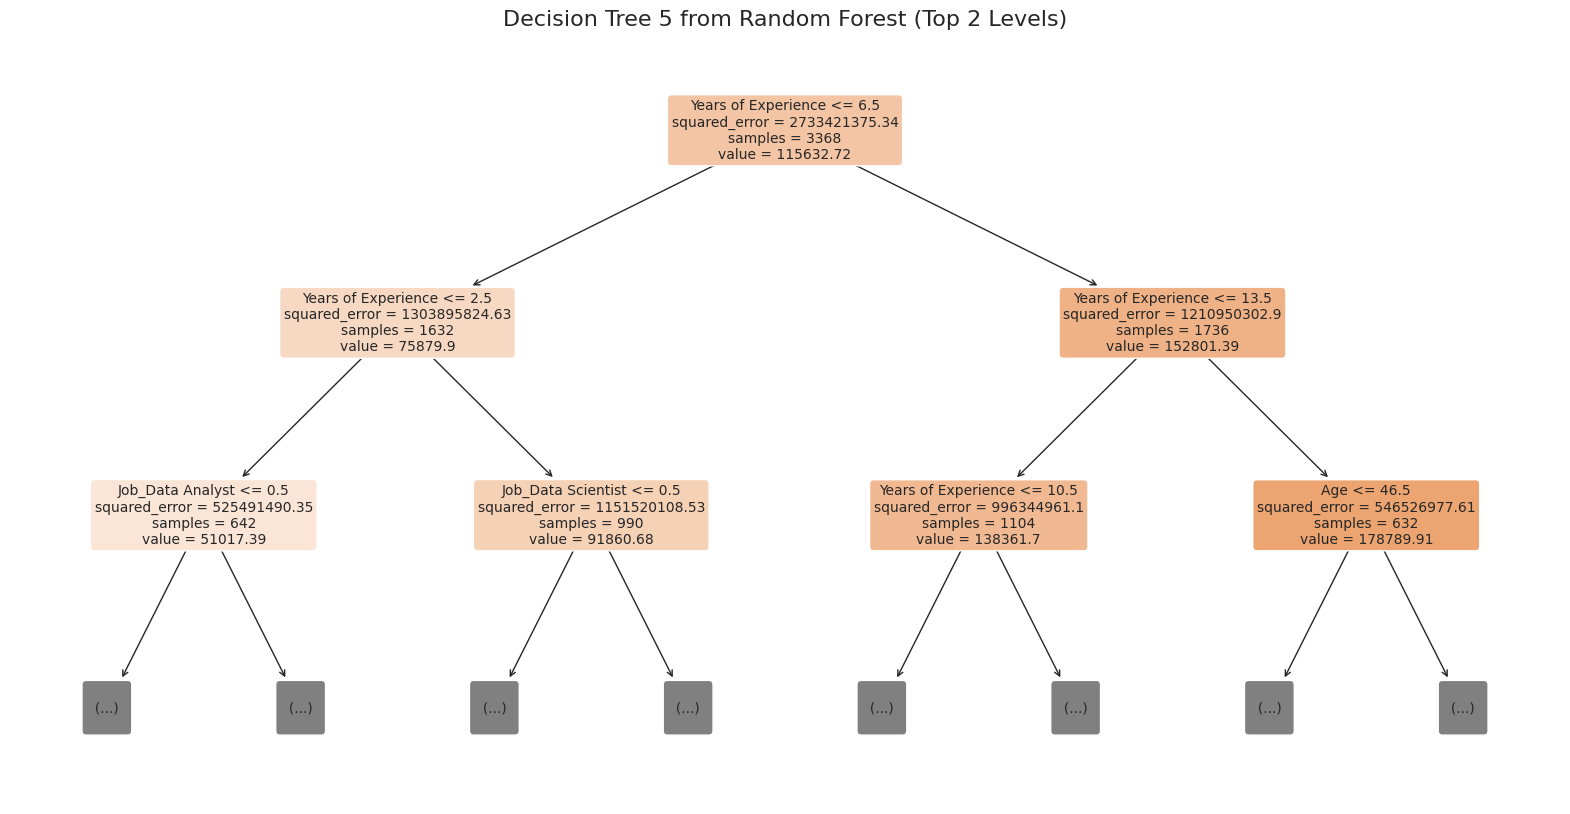

In [28]:
from sklearn.tree import plot_tree

best_rf_model = best_estimators['Random_Forest']
n_trees_to_plot = 5
plot_max_depth = 2
fig_width = 20  
fig_height = 10      

feature_names = X_train.columns.tolist()
n_trees_to_plot = min(n_trees_to_plot, len(best_rf_model.estimators_))

print(f"\nVisualizing the first {n_trees_to_plot} trees from the Random Forest model (up to depth {plot_max_depth})...")

for i in range(n_trees_to_plot):
    tree_to_plot = best_rf_model.estimators_[i]
    plt.figure(figsize=(fig_width, fig_height))
    plot_tree(
        tree_to_plot,
        feature_names=feature_names,
        filled=True,
        rounded=True,
        precision=2,
        fontsize=10,
        max_depth=plot_max_depth
    )
    plt.title(f'Decision Tree {i + 1} from Random Forest (Top {plot_max_depth} Levels)', fontsize=16)
    plt.show()

# Saving the Model

In [29]:
import joblib
import os

In [30]:
model_to_save = best_estimators.get('Random_Forest')
label_encoder_to_save = le
education_map_to_save = education_mapping
model_columns_to_save = X_train.columns.tolist()

In [31]:
output_dir = 'salary_model_files'
os.makedirs(output_dir, exist_ok=True)

model_filename = os.path.join(output_dir, 'random_forest_salary_model.joblib')
encoder_filename = os.path.join(output_dir, 'gender_label_encoder.joblib')
edu_map_filename = os.path.join(output_dir, 'education_mapping.joblib')
columns_filename = os.path.join(output_dir, 'model_columns.joblib')

In [32]:
# Check if model exists before saving
if model_to_save:
    print(f"Saving model to: {model_filename}")
    joblib.dump(model_to_save, model_filename)
    
    print(f"Saving label encoder to: {encoder_filename}")
    joblib.dump(label_encoder_to_save, encoder_filename)
    
    print(f"Saving education mapping to: {edu_map_filename}")
    joblib.dump(education_map_to_save, edu_map_filename)
    
    print(f"Saving model columns to: {columns_filename}")
    joblib.dump(model_columns_to_save, columns_filename)
    
    print("\nModel and preprocessing objects saved successfully.")
else:
    print("\nError: Best Random Forest model not found. Cannot save.")

Saving model to: salary_model_files/random_forest_salary_model.joblib
Saving label encoder to: salary_model_files/gender_label_encoder.joblib
Saving education mapping to: salary_model_files/education_mapping.joblib
Saving model columns to: salary_model_files/model_columns.joblib

Model and preprocessing objects saved successfully.


# Loading the model for inference

In [33]:
import joblib
import pandas as pd
import numpy as np

In [34]:
output_dir = 'salary_model_files' 
model_filename = os.path.join(output_dir, 'random_forest_salary_model.joblib')
encoder_filename = os.path.join(output_dir, 'gender_label_encoder.joblib')
edu_map_filename = os.path.join(output_dir, 'education_mapping.joblib')
columns_filename = os.path.join(output_dir, 'model_columns.joblib')

In [35]:
try:
    loaded_model = joblib.load(model_filename)
    loaded_encoder = joblib.load(encoder_filename)
    loaded_edu_map = joblib.load(edu_map_filename)
    loaded_model_columns = joblib.load(columns_filename)
    print("Model and preprocessing objects loaded successfully.")
except FileNotFoundError:
    print("Error: One or more model files not found. Please ensure the files exist in the specified directory.")
    # Exit or handle error appropriately
    exit()
except Exception as e:
    print(f"An error occurred during loading: {e}")
    # Exit or handle error appropriately
    exit()

Model and preprocessing objects loaded successfully.


In [36]:
# Define custom input data
custom_data = {
    'Age': [32],
    'Gender': ['Male'],
    'Education Level': ["Master's"],
    'Job Title': ['Data Scientist'],
    'Years of Experience': [8]
}

custom_df = pd.DataFrame(custom_data)
print("\nCustom Input Data:")
custom_df


Custom Input Data:


Age Gender Education Level       Job Title  Years of Experience
0   32   Male        Master's  Data Scientist                    8

In [37]:
# Preprocess the Custom Data EXACTLY as the Training Data
processed_df = custom_df.copy()

# 1. Apply Education Level Mapping
processed_df['Education Level'] = processed_df['Education Level'].map(loaded_edu_map)

# Check if any values failed to map (resulting in NaN)
if processed_df['Education Level'].isnull().any():
     print("Warning: Unknown 'Education Level' encountered in custom data. Prediction might be inaccurate.")

# 2. Apply Gender Label Encoding
try:
    processed_df['Gender'] = loaded_encoder.transform(processed_df['Gender'])
except ValueError as e:
     print(f"Warning: Unknown 'Gender' encountered: {e}. Prediction might be inaccurate.")
     processed_df['Gender'] = 0 # Example: Assigning the code for 'Female' or 'Male' depending on encoding

In [38]:
# 3. Apply One-Hot Encoding for Job Title and Align Columns
processed_df = pd.get_dummies(processed_df, columns=['Job Title'], prefix='Job', drop_first=False) 

In [39]:
processed_df = processed_df.reindex(columns=loaded_model_columns, fill_value=0)

In [40]:
print("\nProcessed Custom Data (Ready for Model):")
processed_df


Processed Custom Data (Ready for Model):


Age  Gender  Education Level  Years of Experience  \
0   32       1                2                    8   

   Job_Content Marketing Manager  Job_Data Analyst  Job_Data Scientist  \
0                              0                 0                True   

   Job_Digital Marketing Manager  Job_Director of Data Science  \
0                              0                             0   

   Job_Director of HR  ...  Job_Senior HR Generalist  \
0                   0  ...                         0   

   Job_Senior Human Resources Manager  Job_Senior Product Marketing Manager  \
0                                   0                                     0   

   Job_Senior Project Engineer  Job_Senior Research Scientist  \
0                            0                              0   

   Job_Senior Software Engineer  Job_Software Developer  \
0                             0                       0   

   Job_Software Engineer  Job_Software Engineer Manager  Job_Web Developer  
0                      0                              0                  0  

[1 rows x 53 columns]

In [41]:
# Make Prediction
try:
    prediction = loaded_model.predict(processed_df)
    predicted_salary = prediction[0] 
    print(f"\nPredicted Salary: ${predicted_salary:,.2f}") 
except Exception as e:
     print(f"\nError during prediction: {e}")


Predicted Salary: $180,244.44
